<a href="https://colab.research.google.com/github/yamilart/DataLabs/blob/main/Using_Batches_unfinished_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐾 Who let the dogs out? 🐾

Final Project: Dog breed detection

A little info:

*   The original [dataset](https://www.kaggle.com/c/dog-breed-identification/overview) consist in 2 folders with over 20000 images of dogs and a csv with 120 breeds. 
*   I edited the dataset a bit (since there where no dachshunds and dachshunds = 💗) and also only worked with the images in the "train" folder
*   This is the 'full' model with 20 breeds, the short version using 10 breeds was made directly on Jupyter notebook and it's called 'Who let 'some' dogs out?'

## Packages

In [ ]:
import os
import cv2
import pickle
import datetime
import warnings
warnings.filterwarnings('ignore')
import itertools
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from IPython.display import display, Image  
from sklearn.model_selection import train_test_split
import datetime
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from matplotlib import pyplot
import tensorflow_hub as hub
from IPython.display import Image
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split
import PIL.Image
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import load_model, Model
from google.colab import drive
from google.colab.patches import cv2_imshow

## Getting Data & EDA

In [ ]:
# loading & checking data: breeds
drive.mount('/content/drive') # this is to open files from my drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# loading & checking data: breeds
dogbreeds = pd.read_csv('/content/drive/MyDrive/dog-breeds/labelsbreeds.csv') 
# personal note: paths are going to be different on my computer
dogbreeds

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


In [ ]:
dogbreeds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [ ]:
dogbreeds['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
brabancon_griffon        67
komondor                 67
golden_retriever         67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

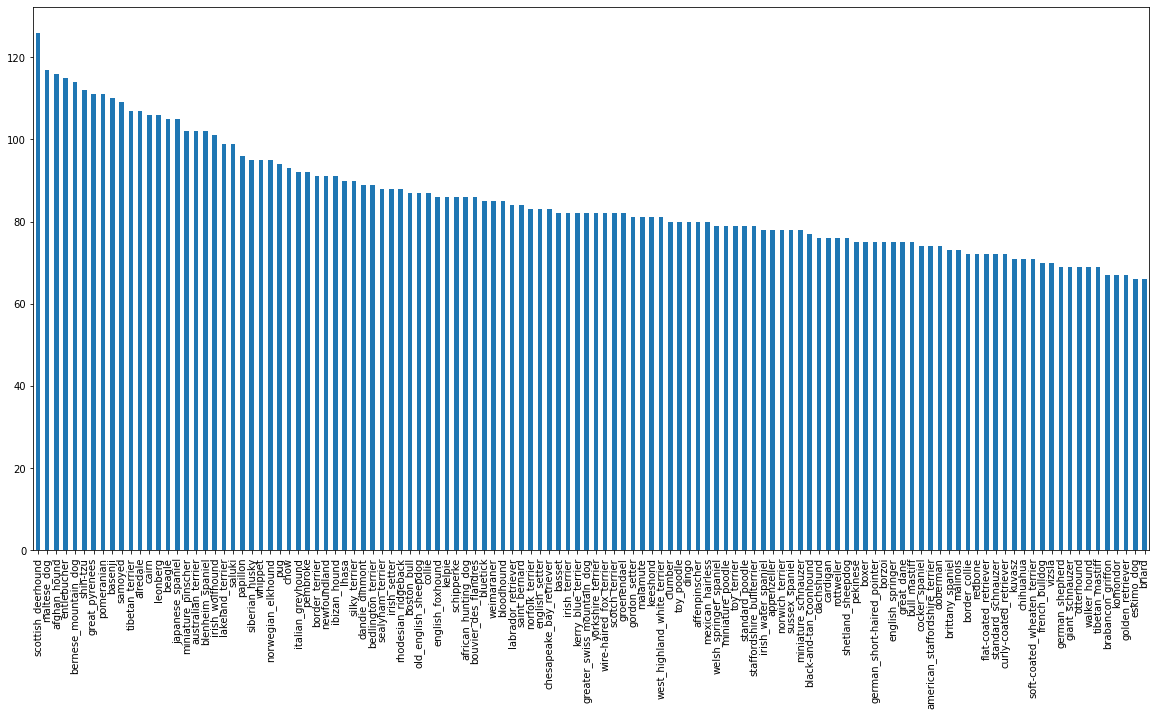

In [ ]:
# visualizing the amount of pictures of each breed
dogbreeds['breed'].value_counts().plot.bar(figsize=(20, 10));

In [ ]:
# checking the breeds
dogbreeds['breed'].unique()

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dachshund', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'b

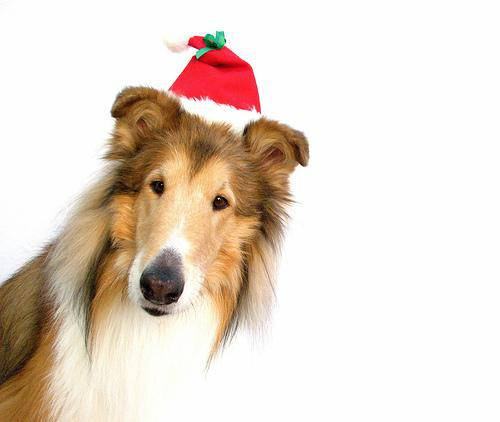

In [ ]:
# naming the picture folder
images = '/content/drive/MyDrive/dog-breeds/trainbreeds/'
# checking a random picture
Image('/content/drive/MyDrive/dog-breeds/trainbreeds/0a6c192b96e55e2ca37318919b1ffae6.jpg')

A festive cutie!

In [ ]:
# now i need to get the image path in the csv file
dogs = dogbreeds.copy()
dogs = dogbreeds.assign(image_path = lambda x: images + x['id'] + '.jpg')
dogs

,id,breed,image_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,/content/drive/MyDrive/dog-breeds/trainbreeds/...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,/content/drive/MyDrive/dog-breeds/trainbreeds/...
2,001cdf01b096e06d78e9e5112d419397,pekinese,/content/drive/MyDrive/dog-breeds/trainbreeds/...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,/content/drive/MyDrive/dog-breeds/trainbreeds/...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,/content/drive/MyDrive/dog-breeds/trainbreeds/...
...,...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi,/content/drive/MyDrive/dog-breeds/trainbreeds/...
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont,/content/drive/MyDrive/dog-breeds/trainbreeds/...
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale,/content/drive/MyDrive/dog-breeds/trainbreeds/...
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher,/content/drive/MyDrive/dog-breeds/trainbreeds/...


In [ ]:
# got to make sure I don't have any nulls there since I edited the original data
dogs.isna().sum()

id            0
breed         0
image_path    0
dtype: int64

In [ ]:
# checking if it works, if I call the id of the picture before I shold get a... border collie?
dogs.loc[dogbreeds['id'] == '0a6c192b96e55e2ca37318919b1ffae6']

,id,breed,image_path
434,0a6c192b96e55e2ca37318919b1ffae6,collie,/content/drive/MyDrive/dog-breeds/trainbreeds/...


Collie & Border Collie are different breeds apparently! The more you learn...

In [ ]:
# checking one more because: dogs
dogs['breed'][42]

'dachshund'

In [ ]:
# locating the id to find the picture
dogs.iloc[42]

id                             011e06760794850c40f23d6426c40774
breed                                                 dachshund
image_path    /content/drive/MyDrive/dog-breeds/trainbreeds/...
Name: 42, dtype: object

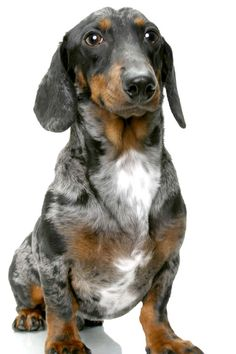

In [ ]:
Image(dogs['image_path'][42])

Oh god, so cute

In [ ]:
# making a copy of the data just in case
somedogs = dogs.copy()

## Selecting data

Since 120 breeds is **A LOT OF DATA TO WORK WITH** I'm going to be realistic and will choose only 20 breeds to start.  
The selection is based on breeds I can recognize and also look quite different to see if this helps the model (or not)

In [ ]:
# breed selection: 
somedogs = somedogs.loc[somedogs['breed'].isin(['dachshund', 'golden_retriever', 'chow', 'siberian_husky', 
                                                'great_dane', 'french_bulldog', 'rottweiler', 'cocker_spaniel', 
                                                'pekinese', 'doberman', 'boxer', 'labrador_retriever', 
                                                'samoyed', 'beagle', 'chihuahua', 'toy_terrier', 
                                                'basset', 'collie', 'bloodhound', 'yorkshire_terrier'])]
somedogs.reset_index(drop = True, inplace = True)
somedogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1634 entries, 0 to 1633
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1634 non-null   object
 1   breed       1634 non-null   object
 2   image_path  1634 non-null   object
dtypes: object(3)
memory usage: 38.4+ KB


In [ ]:
somedogs['breed'].value_counts()

samoyed               109
beagle                105
siberian_husky         95
chow                   93
collie                 87
bloodhound             85
labrador_retriever     84
yorkshire_terrier      82
basset                 82
toy_terrier            79
dachshund              76
rottweiler             76
boxer                  75
great_dane             75
pekinese               75
doberman               74
cocker_spaniel         74
chihuahua              71
french_bulldog         70
golden_retriever       67
Name: breed, dtype: int64

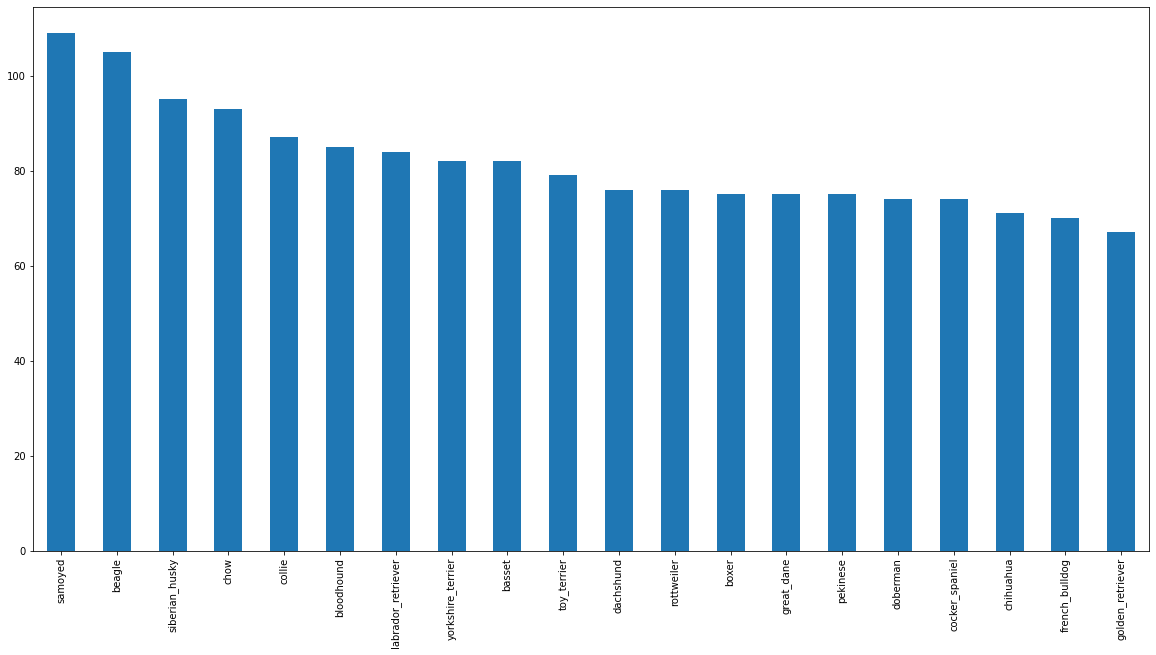

In [ ]:
# the amount of pictures of each breed: the graph way
somedogs['breed'].value_counts().plot.bar(figsize=(20, 10));

## Transforming data
I need to transform the data in order to work with it since I basically have images and a bunch of texts.

### Breeds
First I'm turning the breeds into arrays
 

In [ ]:
# getting a string of all the breeds and a list of the unique values
string_breeds = np.array(somedogs.breed)
unique_breeds = np.unique(string_breeds)
# turning every breed
breeds = [breed == np.array(unique_breeds) for breed in string_breeds]

### Variables X & y

In [ ]:
X = somedogs['image_path'] # images
y = breeds # breeds (in arrays)

In [ ]:
# split the dataset: 70% for training and 30% for testing. Randomness at 42 because it's the answer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
# checking if lengths are equal
print(len(X_train), len(y_train), len(X_test), len(y_test))

1143 1143 491 491


### Images
I need to resize my images (going to use 224 x 224), add a color layer (RGB: 3), turn the images into arrays and scale that array from -1 to 1.
So I'm basically turning my images into Tensors to be able to use them with TensorFlow.

In [ ]:
# creating a function to process the image
def img_process(image_path):
# I need to open and read the image
    image = tf.io.read_file(image_path)
# turn it to a numerical Tensor with RGB channel (3)
    image = tf.image.decode_jpeg(image, channels = 3)
# convert the RGB values from 0-225 to 0-1
    image = tf.image.convert_image_dtype(image, tf.float32)
# resize the image, I'm using 224 x 244 since I saw it's a usual size
    image = tf.image.resize(image, size=[224, 224])
    return image

# now I need to return a tuple (image, label) for each image
def get_image_label(image_path, label):
   image = img_process(image_path)
   return image, label

### 'Grouping' the images: creating batches
Working with so many pictures can really slow down the models so I'm 'splitting' the images into groups

In [ ]:
# Create a function to turn data into batches
def create_batches(x, y = None, batch_size = 32, valid_data = False, test_data = False):
  # If the data is a test dataset, we don't have labels
  if test_data:
    # Get the slices of an array in the form of tensors, we only pass filepaths
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
    # Preprocess each image object with our 'process_image' function
    data = data.map(process_image)
    # Turn our data into batches
    data_batch = data.batch(32)
    return data_batch
  
  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    # Get the slices of an array in the form of tensors, we pass filepaths and labels
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
    # Preprocess each (image, label) object with our 'get_image_label' function
    data = data.map(get_image_label)
    # Turn our data into batches
    data_batch = data.batch(32)
    return data_batch

  else:
    # Get the slices of an array in the form of tensors, we pass filepaths and labels
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Preprocess each image object with our 'process_image' function
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(32)
  return data_batch


# Create training and validation data batches
train_data = create_batches(X_train, y_train)
val_data = create_batches(X_test, y_test, valid_data = True)

## Models
I'll be working with the Keras [Sequencial model](https://keras.io/guides/sequential_model/) only, trying different values and layers.   
Since it's a linear stack of layers it's was easier for me to understand it and apply it knowing what I was doing.

Initially I had planned to apply also a Functional Model bulding a ResNet but I really couldn't understand the process and my loss values where off the roof.   
It's going into my Wishlist.


**Defining first steps**

In [ ]:
# Setup input shape to the model = batch, height, width, colour channels
in_shape = [None, 224, 224, 3] 

# Setup output shape of the model = amount of unique breeds
out_shape = len(somedogs['breed'].unique())

# Create early stopping (once the model stops improving, stop training) Patience is the number of improvements
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience = 4)

# How many rounds should we get the model to look through the data?
num_epochs = 25

# Setup model URLs from TensorFlow Hub
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

### First Model

In [ ]:
model = tf.keras.models.Sequential()
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(300, activation = 'relu'))
model.add(keras.layers.Dense(100, activation = 'relu'))
model.add(keras.layers.Dense(out_shape, activation = 'softmax'))
model.build(in_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 300)               45158700  
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 20)                2020      
                                                                 
Total params: 45,190,820
Trainable params: 45,190,820
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy']
              )

history = model.fit(x = train_data,
          epochs = num_epochs,
          validation_data = val_data,
          validation_freq = 1, # check validation metrics every epoch
          callbacks = early_stopping)

Epoch 1/25
36/36 [==============================] - 172s 5s/step - loss: 47.0531 - accuracy: 0.0455 - val_loss: 11.5407 - val_accuracy: 0.0591
Epoch 2/25
36/36 [==============================] - 7s 191ms/step - loss: 6.6041 - accuracy: 0.0726 - val_loss: 3.0012 - val_accuracy: 0.0550
Epoch 3/25
36/36 [==============================] - 7s 187ms/step - loss: 3.0001 - accuracy: 0.0472 - val_loss: 2.9962 - val_accuracy: 0.0489
Epoch 4/25
36/36 [==============================] - 7s 189ms/step - loss: 2.9947 - accuracy: 0.0455 - val_loss: 2.9971 - val_accuracy: 0.0468
Epoch 5/25
36/36 [==============================] - 9s 241ms/step - loss: 2.9943 - accuracy: 0.0717 - val_loss: 2.9962 - val_accuracy: 0.0509


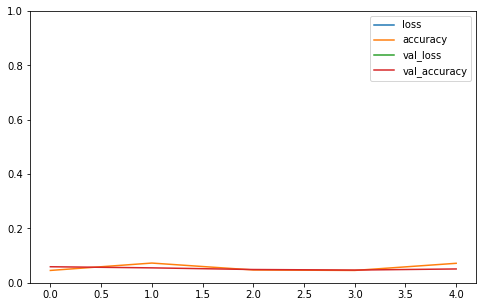

In [ ]:
pd.DataFrame(history.history).plot(figsize = (8,5))
pyplot.grid = (True)
pyplot.gca().set_ylim(0,1)
pyplot.show()

A lame first attempt, but hey, it was my first Model! *#proud*

### Second Model

In [ ]:
model2 = tf.keras.models.Sequential()
model2.add(hub.KerasLayer(model_url))
model2.add(keras.layers.Dense(out_shape, activation = 'softmax'))
model2.build(in_shape)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense_3 (Dense)             (None, 20)                20040     
                                                                 
Total params: 5,452,753
Trainable params: 20,040
Non-trainable params: 5,432,713
_________________________________________________________________


In [ ]:
model2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"]
              )

history2 = model2.fit(x = train_data,
          epochs = num_epochs,
          validation_data = val_data,
          validation_freq = 1, # check validation metrics every epoch
          callbacks = early_stopping
          )

Epoch 1/25
36/36 [==============================] - 16s 364ms/step - loss: 1.6718 - accuracy: 0.5389 - val_loss: 0.5133 - val_accuracy: 0.8758
Epoch 2/25
36/36 [==============================] - 12s 336ms/step - loss: 0.2627 - accuracy: 0.9379 - val_loss: 0.3293 - val_accuracy: 0.9043
Epoch 3/25
36/36 [==============================] - 10s 279ms/step - loss: 0.1363 - accuracy: 0.9781 - val_loss: 0.2907 - val_accuracy: 0.9104
Epoch 4/25
36/36 [==============================] - 12s 340ms/step - loss: 0.0850 - accuracy: 0.9948 - val_loss: 0.2724 - val_accuracy: 0.9145
Epoch 5/25
36/36 [==============================] - 10s 274ms/step - loss: 0.0602 - accuracy: 0.9983 - val_loss: 0.2612 - val_accuracy: 0.9124
Epoch 6/25
36/36 [==============================] - 13s 353ms/step - loss: 0.0450 - accuracy: 0.9991 - val_loss: 0.2559 - val_accuracy: 0.9267
Epoch 7/25
36/36 [==============================] - 10s 278ms/step - loss: 0.0356 - accuracy: 0.9991 - val_loss: 0.2521 - val_accuracy: 0.9206

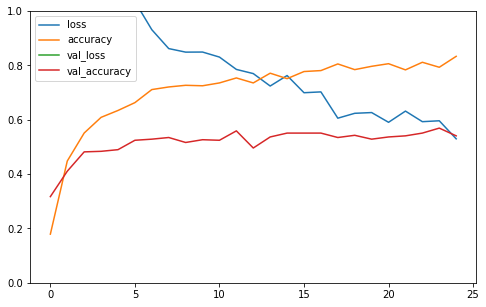

In [ ]:
pd.DataFrame(history2.history).plot(figsize = (8,5))
pyplot.grid = (True)
pyplot.gca().set_ylim(0,1)
pyplot.show()

Accuracy is at 80%! But the validation accuracy is only 57%

### Third Model

In [ ]:
model3 = tf.keras.models.Sequential()
model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(500, activation = 'relu'))
model3.add(keras.layers.Dense(250, activation = 'relu'))
model3.add(keras.layers.Dense(out_shape, activation = 'softmax'))
model3.build(in_shape)
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_7 (Dense)             (None, 500)               75264500  
                                                                 
 dense_8 (Dense)             (None, 250)               125250    
                                                                 
 dense_9 (Dense)             (None, 20)                5020      
                                                                 
Total params: 75,394,770
Trainable params: 75,394,770
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model3.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"]
              )

history3 = model3.fit(x = train_data,
          epochs = num_epochs,
          validation_data = val_data,
          validation_freq = 1, # check validation metrics every epoch
          callbacks = early_stopping)

Epoch 1/25
36/36 [==============================] - 11s 284ms/step - loss: 72.7996 - accuracy: 0.0604 - val_loss: 25.2776 - val_accuracy: 0.0448
Epoch 2/25
36/36 [==============================] - 9s 252ms/step - loss: 10.5560 - accuracy: 0.0910 - val_loss: 5.4395 - val_accuracy: 0.0530
Epoch 3/25
36/36 [==============================] - 9s 236ms/step - loss: 4.3165 - accuracy: 0.1260 - val_loss: 5.1955 - val_accuracy: 0.0835
Epoch 4/25
36/36 [==============================] - 9s 256ms/step - loss: 3.3735 - accuracy: 0.1662 - val_loss: 3.5422 - val_accuracy: 0.1181
Epoch 5/25
36/36 [==============================] - 9s 261ms/step - loss: 2.9387 - accuracy: 0.1899 - val_loss: 3.4822 - val_accuracy: 0.0916
Epoch 6/25
36/36 [==============================] - 9s 258ms/step - loss: 3.0331 - accuracy: 0.2047 - val_loss: 3.9576 - val_accuracy: 0.0896
Epoch 7/25
36/36 [==============================] - 9s 263ms/step - loss: 2.6598 - accuracy: 0.2310 - val_loss: 3.7385 - val_accuracy: 0.0754
Ep

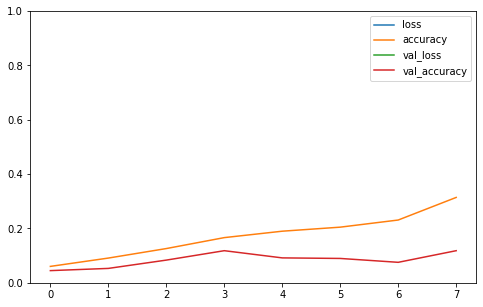

In [ ]:
pd.DataFrame(history3.history).plot(figsize = (8,5))
pyplot.grid = (True)
pyplot.gca().set_ylim(0,1)
pyplot.show()

In [ ]:
#Save the best model for prediction
model2.save("bestmodel_mobilenet")

INFO:tensorflow:Assets written to: bestmodel_mobilenet/assets


INFO:tensorflow:Assets written to: bestmodel_mobilenet/assets


### Testing the best model

Testing the best model with a random picture (my dog Ozzy)

In [ ]:
#load the model
model = load_model('/content/drive/My Drive/dog-breeds/20211215-20561639601788-20-breeds.h5')
 
#get the image of the dog for prediction
dog_img_path = '/content/drive/MyDrive/dog-breeds/ozzy.jpg'
#read the image file and convert into numeric format
#resize all images to one dimension i.e. 224x224
dog_img_array = cv2.resize(cv2.imread(dog_img_path,cv2.IMREAD_COLOR),((224,224)))
#scale array into the range of -1 to 1.
#expand the dimension on the axis 0 and normalize the array values
dog_img_array = preprocess_input(np.expand_dims(np.array(dog_img_array[...,::-1].astype(np.float32)).copy(), axis=0))
 
#feed the model with the image array for prediction
pred_val = model.predict(np.array(dog_img_array,dtype="float32"))
 
#display the image of dog
#cv2.imshow(cv2.resize(cv2.imread(dog_img_path,cv2.IMREAD_COLOR),((224,224)))) 
Image(cv2.resize(cv2.imread(dog_img_path,cv2.IMREAD_COLOR),((224,224)))) 
 
#display the predicted breed of dog
pred_breed = sorted(somedogs['breed'])[np.argmax(pred_val)]
print("This Dog is a:",pred_breed)

Loading saved model from: /content/drive/My Drive/dog-breeds/20211215-20561639601788-20-breeds.h5
This Dog is a: basset
